# Exercises

## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF? 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

palette = sns.color_palette("tab10")
sns.set_theme(
    context="paper",
    style="white",
    palette=palette,
    font="Times New Roman",
    font_scale=1.5
)

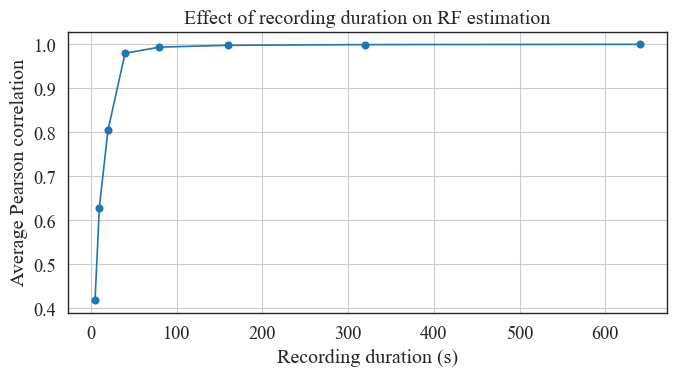

In [2]:
# Stimulus settings
time_step = 0.1
stim_std = 1.0
field_shape = (15, 15)
recording_durations = [5, 10, 20, 40, 80, 160, 320, 640]

# Receptive field properties
rf_center = (8, 8)
rf_sigma = (4, 4)
rf_orientation_deg = 45
rf_frequency = 0.085
rf_phase = 0

# Simulation parameters
response_noise_var = 1.0
bias_term = 2.0
n_repeats = 10

# Create spatial grid
x, y = np.meshgrid(
    np.arange(1, field_shape[0] + 1),
    np.arange(1, field_shape[1] + 1),
    indexing='ij'
)

# Generate receptive field
gaussian_env = np.exp(
    -((x - rf_center[0]) ** 2) / (2 * rf_sigma[0] ** 2)
    - ((y - rf_center[1]) ** 2) / (2 * rf_sigma[1] ** 2)
)

theta = np.deg2rad(rf_orientation_deg)
rotated_coords = (x * np.cos(theta) + y * np.sin(theta)) * 2 * np.pi * 2 * rf_frequency
sine_modulation = np.cos(rotated_coords + rf_phase)

rf_kernel = gaussian_env * sine_modulation
rf_kernel /= np.max(np.abs(rf_kernel))

rf_vector = np.append(rf_kernel.ravel(), bias_term)

mean_correlations = []

for duration in recording_durations:
    n_time_bins = int(round(duration / time_step))
    correlations = []

    for _ in range(n_repeats):
        stimulus = stim_std * np.random.randn(n_time_bins, *field_shape)
        stimulus_flat = stimulus.reshape(n_time_bins, -1)
        stimulus_flat = np.hstack([stimulus_flat, np.ones((n_time_bins, 1))])

        projection = rf_vector @ stimulus_flat.T
        noisy_response = projection + \
            np.sqrt(response_noise_var) * np.random.randn(n_time_bins)

        estimated_rf = np.linalg.pinv(stimulus_flat) @ noisy_response
        estimated_rf = estimated_rf[:-1].reshape(field_shape)

        cc = np.corrcoef(rf_kernel.ravel(), estimated_rf.ravel())[0, 1]
        correlations.append(cc)

    mean_correlations.append(np.mean(correlations))

# Plot results
plt.figure(figsize=(7, 4))
plt.plot(recording_durations, mean_correlations, marker='o')
plt.xlabel('Recording duration (s)')
plt.ylabel('Average Pearson correlation')
plt.title('Effect of recording duration on RF estimation')
plt.grid(True)
plt.tight_layout()
plt.show()

In the above plot, we see that the accuracy of receptive field estimation improves rapidly with increasing recording duration. There is a steep rise in correlation for durations up to about 80 seconds, indicating that most of the RF structure is learned early. Beyond that point, performance continuously approaching a perfect estimation (correlation = 1). This indicates that a moderate-duration recording can be sufficient for reliable RF estimation under low-noise conditions.

## Exercise 2
---
Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.

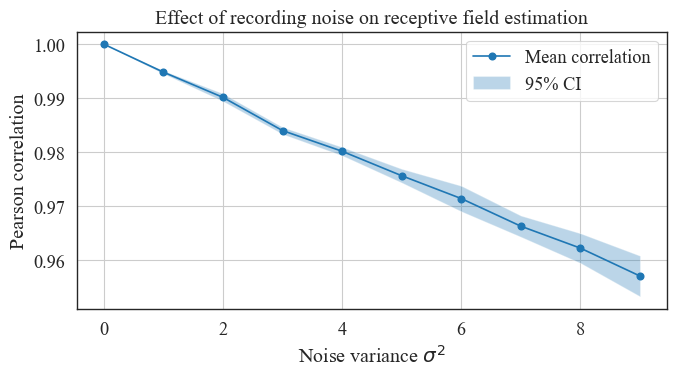

In [3]:
# Simulation setup
fixed_duration = 100  # seconds
noise_levels = np.arange(0, 10, 1)
n_time_bins = int(round(fixed_duration / time_step))

mean_correlations = []
sem_correlations = []

for noise_var in noise_levels:
    correlations = []

    for _ in range(n_repeats):
        stimulus = stim_std * np.random.randn(n_time_bins, *field_shape)
        stimulus_flat = np.hstack([
            stimulus.reshape(n_time_bins, -1),
            np.ones((n_time_bins, 1))
        ])

        projection = rf_vector @ stimulus_flat.T
        noisy_response = projection + np.sqrt(noise_var) * np.random.randn(n_time_bins)

        estimated_rf = np.linalg.pinv(stimulus_flat) @ noisy_response
        cc = np.corrcoef(rf_vector[:-1], estimated_rf[:-1])[0, 1]
        correlations.append(cc)

    correlations = np.array(correlations)
    mean_correlations.append(np.mean(correlations))
    sem_correlations.append(np.std(correlations, ddof=1) / np.sqrt(n_repeats))

mean_correlations = np.array(mean_correlations)
sem_correlations = np.array(sem_correlations)
conf_interval = 1.96 * sem_correlations 

# Plotting
plt.figure(figsize=(7, 4))
plt.plot(noise_levels, mean_correlations, '-o', label='Mean correlation')
plt.fill_between(
    noise_levels,
    mean_correlations - conf_interval,
    mean_correlations + conf_interval,
    alpha=0.3,
    label='95% CI',
)
plt.xlabel(r'Noise variance $\sigma^2$')
plt.ylabel('Pearson correlation')
plt.title('Effect of recording noise on receptive field estimation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Exercise 3
---
Look at the analytical derivation of the log-likelihood for the poisson GLM.
Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$ and which terms can be ignored? **Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier. 




We can re-write the log-likelihood as:

\begin{equation*}
    \log P(R | S, k) = \sum_t r_t\log \lambda_t + \sum_t r_t\log \Delta - \sum_t \log r_t! - \Delta \sum_t \lambda_t
\end{equation*}

In the above equation, two terms can be discarded: $\sum_t r_t\log \Delta$ and $\sum_t \log r_t!$, since adding or subtracting a constant does not change the location of a maximum.

The log-likelihood is then reduced to:
\begin{equation*}
    \log P(R | S, k) = \sum_t r_t\log \lambda_t  - \Delta \sum_t \lambda_t = \sum_t r_tk^Ts_t - \Delta \sum_t \exp(k^Ts_t)
\end{equation*}

## Exercise 4
---
Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

A - Generate data with durations of 10,20,50,100 and 200 seconds. Fit the model on each dataset and plot the fitted parameters.
Use the pearson correlation as a proxy of the goodness of fit, and plot it as a function of the duration of the data.

B - Fix the duration to 100s, and change the average firing rate of the simulation. How does the fit perform for different firing rates? 